# Intro
- This is the first jupyter notebook for the EIA interhemispheric assymmetry (IHA) seen during different solar cycles
- TEC comparison during the March equinox is carried out for different years
    - Peaks of the north and south EIA are traced and compared

# Reading New TEC Data and Producing Output Files

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import cartopy.crs as ccrs
from tqdm import tqdm
from apexpy import Apex
import os
import datetime as dt
import importlib as il

from p_tqdm import p_map
from multiprocessing import Pool
import itertools

In [13]:
# Choose the system: i -> 0:tacc, 1:mac, 2:ganymede
i = 1

if i == 0:
    work = '/work/10028/prasoonv/ls6/repo/sat-interp-tid-analysis/'
    scratch = '/scratch/10028/prasoonv/' 
elif i == 1:
    work = '/Users/prasoonv/repo/sat-interp-tid-analysis/'
    scratch = '/Users/prasoonv/repo/sat-interp-tid-analysis/scratch/'
elif i == 2:
    work = '/home/pxv220016/prasoon/data/sat_interp_repo/sat-interp-tid-analysis/'
    scratch = '/home/pxv220016/scratch/'

import sys
sys.path.append('')
sys.path.append(f'{work}prasoon_utility_programs')
sys.path.append(f'{work}Qingyu_Cesar_EIA_IHA')
import functions

In [ ]:
functions = il.reload(functions)
month = 'sept' #'march'

if month == 'sept' or month == 'march':
    phase = 'equinox'
else:
    phase = 'solstice'

if month == 'dec':
    years_tot = list(range(2000, 2024))
else:
    years_tot = list(range(2024, 2025))
    
for year in tqdm(years_tot):
    
    print(year)

    
    # Reading Madrigal Cedar data for +- 21 days around March equinox of 2010-2024
    # Files in below scratch folder are obtained by using multiple file download 
    # command in ASCII format and then doing `gunzip file.gz`  
    path = f'{scratch}Qingyu_Cesar_EIA/' + month + '_data/' + str(year) + '_' + month + '_' + phase + '/'
    files = os.listdir(path)
    files = [path + i for i in files]

    for f in files:
        if f[-4:] != '.txt':
            files.remove(f)
            
    print(len(files))
    
    tec_g = []
    columns = ['GDLAT', 'GLON', 'TEC', 'DT']
    grnd_tec = pd.DataFrame(columns=columns)
    
    def process_file(f):
        # Read function passed continuously during multiple processing to quicken the process
        df = pd.read_csv(f, sep=r'\s+')
        d = [dt.datetime(y, m, d, h, mi, s) for y, m, d, h, mi, s in zip(df.YEAR, df.MONTH, df.DAY, df.HOUR, df.MIN, df.SEC)]
        df['DT'] = d
        # Dropping unnecassary columns from the Dataframe
        df = df.drop(['RECNO', 'KINDAT', 'KINST', 'UT1_UNIX', 'UT2_UNIX', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'MIN', 'SEC', 'DTEC'], axis=1)
        if 'GDALT' in df.columns:
            df = df.drop(['GDALT'], axis=1)
        df = df[(df.GDLAT > -60) & (df.GDLAT < 60) & (df.GLON > -85) & (df.GLON < -45)].reset_index(drop=True)
        return df    
    # Speeding the process by using parallel processing
    tec_g = p_map(process_file, files)  # Parallel processing with progress bar
    print('1')
    grnd_tec = pd.concat(tec_g, axis=0).reset_index(drop=True)
    grnd_tec0 = grnd_tec.sort_values(by=['DT', 'GDLAT'], ascending=[True, True])


    # Reading the Kp index values for all the days and filtering undesired points where Kp > 3
    file = f'{work}Qingyu_Cesar_EIA_IHA/kp3_index_values/kp_{str(year)}_{month}.txt'
    kp = pd.read_csv(file,sep=r'\s+')
    date_kp = [functions.day_to_date(i, year) for i in kp.DOY]
    m, d = zip(*date_kp)
    kp['date'] = [dt.datetime(year, j, i, k, 0, 0) for i,j,k in zip(d,m,kp.Hour)]
    kp['kp'] = [i/10 for i in kp.Kp]
    kp = kp.drop(['Year', 'DOY', 'Hour','Kp'], axis = 1)
    merged_data = pd.merge_asof(grnd_tec0.sort_values('DT'), kp.sort_values('date'), left_on='DT', right_on='date', direction='backward')
    grnd_tec0 = merged_data.drop(['date'], axis = 1)
    print('2')

    # Calculation of magnetic coordinates by using Apex library and Parallel prcoessing 
    t_start = dt.datetime.now() # just a timer
    with Pool(36) as pool:
        p = pool.starmap(functions.magnetic_coords_parallel, zip(grnd_tec0.DT, grnd_tec0.GDLAT, grnd_tec0.GLON, grnd_tec0.TEC))
    pool.close()
    pool.join()
    # Separating the data from output list 
    sat_date, sat_glat, sat_glon, sat_tec, sat_mlat, sat_mlon, sat_mlt = zip(*p)
    t_total = dt.datetime.now() - t_start
    print(t_total)
    

    # Reordering the outputs and applying further conditions on magnetic coordinates
    grnd_temp = pd.DataFrame({'DT': sat_date, 'GDLAT': sat_glat, 'GLON': sat_glon, 'TEC': sat_tec, 'MLAT': sat_mlat, 'MLON': sat_mlon, 'MLT': sat_mlt})
    grnd_tec1 = grnd_temp.sort_values(by=['DT', 'GDLAT'], ascending=[True, True]).reset_index()
    grnd_tec1 = grnd_tec1[(grnd_tec1.MLON <= 5) & (grnd_tec1.MLON >= -5)].reset_index(drop=True)
    grnd_tec1 = grnd_tec1[(grnd_tec1.MLAT <= 40) & (grnd_tec1.MLAT >= -40)].reset_index(drop=True)
    grnd_tec2 = grnd_tec1.drop(['GDLAT', 'GLON','MLON'], axis = 1)

    
    # Writing the output into csv files for easy post processing
    grnd_tec2.to_csv(f'{scratch}Qingyu_Cesar_EIA/outputs/{month}/{str(year)}_{month}_{phase}.csv', index=False)


  0%|                                                                                                                         | 0/1 [00:00<?, ?it/s]

2024
40


  0%|          | 0/40 [00:00<?, ?it/s]

# F10.7 Comparison for March 2023 and 2024

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import cartopy.crs as ccrs
from tqdm import tqdm
from apexpy import Apex
import datetime as dt


In [ ]:
# Choose the system: i -> 0:tacc, 1:mac, 2:ganymede
i = 1

if i == 0:
    work = '/work/10028/prasoonv/ls6/repo/sat-interp-tid-analysis/'
    scratch = '/scratch/10028/prasoonv/' 
elif i == 1:
    work = '/Users/prasoonv/repo/sat-interp-tid-analysis/'
    scratch = '/Users/prasoonv/repo/sat-interp-tid-analysis/scratch/'
elif i == 2:
    work = '/home/pxv220016/prasoon/data/sat_interp_repo/sat-interp-tid-analysis/'
    scratch = '/home/pxv220017/scratch/'

import sys
sys.path.append('')
sys.path.append(f'{work}prasoon_utility_programs')
sys.path.append(f'{work}Qingyu_Cesar_EIA_IHA')
import functions

In [ ]:
functions = il.reload(functions)
f107_years = [2023, 2024]
month = 'march'

path = f'{work}Qingyu_Cesar_EIA_IHA/outputs/{month}/f107_{month}_'

columns = ['Year', 'DOY', 'Hour', 'f10_7']
f107 = pd.DataFrame(columns = columns)

for y in f107_years:
    file = f'{path}{str(y)}.txt'
    df_f107 = pd.read_csv(file, sep=r'\s+')
    print(y, 'year -> Mean =', sum(df_f107.f10_7)/len(df_f107.f10_7), 'and Median =', np.median(df_f107.f10_7))
print('\nBoth mean and median of F10.7 index during ' + month + ' equinox for 2023 is higher than 2024.')

2023 year -> Mean = 150.87441860465202 and Median = 148.1
2024 year -> Mean = 146.01395348837212 and Median = 137.6

Both mean and median of F10.7 index during march equinox for 2023 is higher than 2024.


# Reading Data Directly From Saved Output Files

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import cartopy.crs as ccrs
from tqdm import tqdm
import datetime as dt
from scipy.signal import savgol_filter
import statistics
import seaborn as sns


In [2]:
# Choose the system: i -> 0:tacc, 1:mac, 2:ganymede
i = 2

if i == 0:
    work = '/work/10028/prasoonv/ls6/repo/sat-interp-tid-analysis/'
    scratch = '/scratch/10028/prasoonv/' 
elif i == 1:
    work = '/Users/prasoonv/repo/sat-interp-tid-analysis/'
    scratch = '/Users/prasoonv/repo/sat-interp-tid-analysis/scratch/'
elif i == 2:
    work = '/home/pxv220016/prasoon/data/sat_interp_repo/repo2/'
    scratch = '/home/pxv220016/scratch/'

import sys
sys.path.append('')
sys.path.append(f'{work}prasoon_utility_programs')
sys.path.append(f'{work}Qingyu_Cesar_EIA_IHA')
import functions

In [ ]:
month = 'march' #'march'

if month == 'sept' or month == 'march':
    phase = 'equinox'
else:
    phase = 'solstice'

if month == 'dec' or month == 'sept':
    years_tot = list(range(2006, 2024))
else:
    years_tot = list(range(2006, 2025))


for year in tqdm(years_tot):
    # Reading the data from output csv
    grnd_tec2 = pd.read_csv(f'{scratch}Qingyu_Cesar_EIA/outputs/{month}/{str(year)}_{month}_{phase}.csv')
    grnd_tec2 = grnd_tec2[grnd_tec2['TEC'] < 250].reset_index(drop=True)
    grnd_tec2 = grnd_tec2[grnd_tec2['kp'] <= 3].reset_index(drop=True)
    print(grnd_tec2)
    grnd_tec2 = grnd_tec2.drop(['kp'], axis = 1)
    
    # Define the bin edges for MLAT and MLT
    bins_mlat = pd.cut(grnd_tec2['MLAT'], bins=pd.interval_range(start=-40, end=40, freq=1))
    bins_mlt = pd.cut(grnd_tec2['MLT'], bins=pd.interval_range(start=0, end=24, freq=0.25))
    
    # Create a new DataFrame with the bins
    grnd_tec2['MLAT_b'] = bins_mlat
    grnd_tec2['MLT_b'] = bins_mlt
    
    # Group by the bins (MLAT_b (primary) and MLT_b (secondary)) and calculate the average of TEC
    grouped = grnd_tec2.groupby(['MLT_b', 'MLAT_b'], observed=False)['TEC']
    result = grouped.agg(
        mean=lambda x: x.mean(skipna=True),
        std=lambda x: x.std(skipna=True),
        min=lambda x: x.min(skipna=True),
        max=lambda x: x.max(skipna=True),
        q25=lambda x: x.quantile(0.25),
        q75=lambda x: x.quantile(0.75)
    ).reset_index()
    result = result.rename(columns={'mean':'TEC'})

    # Converting the midpoint values of bins to float and assigning average TEC at those points
    result['MLAT_b'] = result['MLAT_b'].apply(lambda x: x.mid)
    result['MLT_b'] = result['MLT_b'].apply(lambda x: x.mid)
    result['MLAT_b'] = result['MLAT_b'].astype(float)
    result['MLT_b'] = result['MLT_b'].astype(float)
    

    
    result = result[result.MLT_b >= 5].reset_index(drop=True)
    filtered = []
    for t in result['MLT_b'].unique():
        result_f = result[result['MLT_b'] == t].reset_index(drop=True)
        fit = savgol_filter(np.array(result_f.TEC), 10, 2)
        filtered.extend(fit)
    result['TEC'] = filtered
    result = result.groupby(['MLAT_b', 'MLT_b'], observed=False).sum().reset_index()
    
    
    # Identifying NH and SH peaks
    result_t = result[result.MLT_b >= 13].reset_index(drop=True)
    result_n = result_t[result_t.MLAT_b > 0].reset_index(drop=True)
    result_s = result_t[result_t.MLAT_b < 0].reset_index(drop=True)
    result_n = result_n.loc[result_n.groupby('MLT_b')['TEC'].idxmax()].reset_index(drop=True)
    result_s = result_s.loc[result_s.groupby('MLT_b')['TEC'].idxmax()].reset_index(drop=True)
    # Dropping the cases where the SH peak is not prominent and maxima appears to come at equator
    result_n.loc[result_n['MLAT_b'] < 5, 'TEC'] = np.nan
    result_s.loc[result_s['MLAT_b'] > -5, 'TEC'] = np.nan
    #print(result_s)

    i = 100*2*(result_n.TEC - result_s.TEC)/(result_n.TEC + result_s.TEC)
    result_ind = pd.DataFrame({'mlat_n': result_n['MLAT_b'], 'tec_n': result_n['TEC'], 'tec_min_n': result_n['min'], 
                               'tec_max_n': result_n['max'], 'tec_q25_n': result_n['q25'], 'tec_q75_n': result_n['q75'],
                               'tec_std_n': result_n['std'], 'mlat_s': result_s['MLAT_b'], 'tec_s': result_s['TEC'], 
                               'tec_min_s': result_s['min'], 'tec_max_s': result_s['max'], 'tec_q25_s': result_s['q25'], 
                               'tec_q75_s': result_s['q75'], 'tec_std_s': result_n['std'], 'mlt': result_n['MLT_b'], 'asy': i})
    result_ind.to_csv(f'{work}Qingyu_Cesar_EIA_IHA/outputs/{month}/asy_{str(year)}_{month}.csv', index=False)


    # Creating new dataframe to remove rows where TEC= NaN
    result_n = pd.DataFrame({'mlt': result_ind.mlt, 'mlat_n': result_ind.mlat_n, 'tec_n': result_ind.tec_n})
    result_n = result_n.dropna(subset='tec_n')
    result_s = pd.DataFrame({'mlt': result_ind.mlt, 'mlat_s': result_ind.mlat_s, 'tec_s': result_ind.tec_s})
    result_s = result_s.dropna(subset='tec_s')
    # Set ColumnB to NaN where ColumnA is NaN
    result_ind.loc[result_ind['tec_n'].isna(), ['tec_min_n', 'tec_q25_n', 'tec_q75_n', 'tec_max_n']] = np.nan
    result_ind.loc[result_ind['tec_s'].isna(), ['tec_min_s', 'tec_q25_s', 'tec_q75_s', 'tec_max_s']] = np.nan
        

    file = f'{work}Qingyu_Cesar_EIA_IHA/kp3_index_values/kp_{str(year)}_{month}.txt'
    kp = pd.read_csv(file,sep=r'\s+')
    f10_mean = sum(kp['F10.7'])/len(kp['F10.7'])
    f10_med = statistics.median(kp['F10.7'])
    
    
    # Plotting the TEC plots
    X, Y = np.meshgrid(result.MLT_b.unique(), result.MLAT_b.unique())
    Z = result.TEC.values.reshape(X.shape)
    Z = np.ma.masked_where(Z == 0, Z)

    fig = plt.figure(figsize=(12,8))
    specs = fig.add_gridspec(2, 2, width_ratios=[1,0.025])
    ax1 = fig.add_subplot(specs[0, 0])
    
    if np.max(Z) <= 20:
        contour_levels = list(range(0, 21, 5))
    elif np.max(Z) <= 40:
        contour_levels = list(range(0, 41, 5))
    elif np.max(Z) <= 60:
        contour_levels = list(range(0, 61, 5))
    elif np.max(Z) <= 80:
        contour_levels = list(range(0, 81, 5))
    elif np.max(Z) <= 100:
        contour_levels = list(range(0, 101, 5))
    elif np.max(Z) <= 120:
        contour_levels = list(range(0, 121, 5))
    elif np.max(Z) <= 140:
        contour_levels = list(range(0, 141, 5))
    elif np.max(Z) <= 160:
        contour_levels = list(range(0, 161, 5))
        
    c = ax1.contourf(X, Y, Z, levels=contour_levels, cmap = 'jet')
    ax1.scatter(result_n.mlt, result_n.mlat_n, c='b', s=30)
    ax1.scatter(result_s.mlt, result_s.mlat_s, c='b', s=30)
    ax1.set_title(f'Tracing EIA Peaks - {str(year)} {month} {phase} (F10.7 mean={str(f10_mean)[:5]}, median={str(f10_med)})')
    ax1.set_ylabel('MLAT')
    ax1.set_xlabel('MLT')
    ax1.grid(True)
    
    # Set ylim conditionally
    if np.max(Z) <= 40:
        ax1.set_ylim(top=40)

    cbar_ax = fig.add_subplot(specs[0,1])
    cbar = fig.colorbar(c, cax=cbar_ax, label='VTEC (TECUnits)', extend='both')

    # Plotting Box and Whiskers plots for Northern and Southern Peaks
    ax2 = fig.add_subplot(specs[1,0])
    for idx, (i, mean, min_val, max_val, q25, q75) in enumerate(zip(result_ind['mlt'], result_ind['tec_n'], result_ind['tec_min_n'], result_ind['tec_max_n'], result_ind['tec_q25_n'], result_ind['tec_q75_n'])):
        # Draw the "box" from 25th percentile to 75th percentile
        ax2.plot([i, i], [q25, q75], color='g', label='NH Peak' if idx == 0 else "", lw=6)  # Box line
        # Draw the "whiskers" from min to max        
        ax2.plot([i, i], [min_val, q25], color='black', lw=1.5)  # Lower whisker
        ax2.plot([i, i], [q75, max_val], color='black', lw=1.5)  # Upper whisker
        # Plot the mean as a point
        ax2.plot(i, mean, 'ro')  # Mean point
        
    for idx, (i, mean, min_val, max_val, q25, q75) in enumerate(zip(result_ind['mlt'], result_ind['tec_s'], result_ind['tec_min_s'], result_ind['tec_max_s'], result_ind['tec_q25_s'], result_ind['tec_q75_s'])):
        i = i + 0.125
        # Draw the "box" from 25th percentile to 75th percentile
        ax2.plot([i, i], [q25, q75], color='c', label='SH Peak' if idx == 0 else "", lw=6)  # Box line
        # Draw the "whiskers" from min to max
        ax2.plot([i, i], [min_val, q25], color='grey', lw=1.5)  # Lower whisker
        plt.plot([i, i], [q75, max_val], color='grey', lw=1.5)  # Upper whisker
        # Plot the mean as a point
        ax2.plot(i, mean, 'bo')  # Mean point
    ax2.legend()
    ax2.set_xlim(13,24)
    ax2.set_title('Average TEC values of NH and SH Peaks Using Box and Whiskers Plots')
    ax2.set_ylabel('TEC')
    ax2.set_xlabel('MLT')
    plt.tight_layout()
    
    fig.savefig(f'{work}Qingyu_Cesar_EIA_IHA/outputs/eia_peaks/{month}/box_plot_peaks/tec_peaks_{month}_{str(year)}.jpg')
    plt.show()

    '''
    # Obbserving TEC values at 15 MLT on MLAT vs TEC plot
    result_c = result[(result.MLT_b >= hr-0.5) & (result.MLT_b <= hr+0.5)].reset_index(drop=True)
    plt.figure(figsize=(12,4))
    plt.scatter(result_c.MLAT_b, result_c.TEC)
    plt.title(f'TEC values at {hr} MLT of {year} {month} {phase}')
    plt.xlabel('MLATs')
    plt.ylabel('TEC')
    plt.show()
    ''';

[(0.0, 0.25], (0.25, 0.5], (0.5, 0.75], (0.75, 1.0], (1.0, 1.25], ..., (22.75, 23.0], (23.0, 23.25], (23.25, 23.5], (23.5, 23.75], (23.75, 24.0]]
Length: 96
Categories (96, interval[float64, right]): [(0.0, 0.25] < (0.25, 0.5] < (0.5, 0.75] < (0.75, 1.0] ... (23.0, 23.25] < (23.25, 23.5] < (23.5, 23.75] < (23.75, 24.0]]


In [29]:
month = 'march' #'march'

if month == 'sept' or month == 'march':
    phase = 'equinox'
else:
    phase = 'solstice'

if month == 'dec' or month == 'sept':
    years_tot = list(range(2000, 2024))
else:
    years_tot = list(range(2000, 2001))


# Craeting separate dataset for whisker plot variations of each day of each year at fixed time
hr = 20
mlt_yr_cmp = []

for year in tqdm(years_tot):
    # Reading the data from output csv
    grnd_tec2 = pd.read_csv(f'{scratch}Qingyu_Cesar_EIA/outputs/{month}/{str(year)}_{month}_{phase}.csv')
    grnd_tec2 = grnd_tec2[grnd_tec2['TEC'] < 250].reset_index(drop=True)

    result_hr = grnd_tec2[(grnd_tec2.MLT >= (hr - 0.5)) & (grnd_tec2.MLT <= (hr + 0.5))].reset_index(drop=True)
    print('Number of points present ', len(result_hr.MLT.unique()))
    result_hr['DOY'] = [pd.Timestamp(dt.datetime.strptime(i, '%Y-%m-%d %H:%M:%S')).dayofyear for i in result_hr['DT']]
    result_hr = result_hr.drop(['DT', 'MLT', 'index'], axis=1)
    result_hr.loc[result_hr['DOY'] < 40, 'DOY'] += 365
    print('before averaging along mlt \n', result_hr)
    
    # Define the bin edges for MLAT and MLT
    bins_mlat = pd.cut(result_hr['MLAT'], bins=pd.interval_range(start=-40, end=40, freq=1))
    result_hr['MLAT_b'] = bins_mlat
    result_check = result_hr[(result_hr['DOY']==60) & ((result_hr['MLAT'] >= -39.5) & (result_hr['MLAT'] <= -38.5))]
    print((result_check.TEC.mean()))

    result_hr = result_hr.groupby(['DOY', 'MLAT_b'], observed=False)['TEC']
    result_hr = result_hr.agg(
        mean=lambda x: x.mean(skipna=True),
        std=lambda x: x.std(skipna=True),
        min=lambda x: x.min(skipna=True),
        max=lambda x: x.max(skipna=True),
        q25=lambda x: x.quantile(0.25),
        q75=lambda x: x.quantile(0.75)
    ).reset_index()
    result_hr = result_hr.rename(columns={'mean':'TEC'})

    # Converting the midpoint values of bins to float and assigning average TEC at those points
    result_hr['MLAT_b'] = result_hr['MLAT_b'].apply(lambda x: x.mid)
    result_hr['MLAT_b'] = result_hr['MLAT_b'].astype(float)
    print('final \n', result_hr)

    '''
    # Pivot the data to create a 2D grid for contour plotting
    grid = result_hr.pivot_table(index='MLAT_b', columns='DOY', values='TEC')    
    x = grid.columns.values  # DOY values
    y = grid.index.values    # MLAT_b values
    X, Y = np.meshgrid(x, y) # Meshgrid for contour plotting
    Z = grid.values          # TEC values

    plt.figure(figsize=(12, 4))
    contour = plt.contourf(X, Y, Z, cmap='jet')  # You can adjust the colormap
    cbar = plt.colorbar(contour)
    cbar.set_label('TEC')
    plt.xlabel('DOY')
    plt.ylabel('MLAT_b')
    plt.title('TEC Contour Plot')
    plt.show()
    '''
    
    mlt_yr_cmp.append(result_hr)

  0%|                                                     | 0/1 [00:00<?, ?it/s]

Number of points present  32438
before averaging along mlt 
          TEC       MLAT  DOY
0       30.5 -39.328953   60
1       36.6 -24.591455   60
2       37.0 -23.666527   60
3      102.5 -15.331725   60
4      102.0 -14.403580   60
...      ...        ...  ...
32438    5.0 -25.422609  102
32439   65.5 -15.196579  102
32440   87.9 -10.530006  102
32441   85.5  -9.595117  102
32442   47.7  29.944918  102

[32443 rows x 3 columns]
30.469565217391303


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.57s/it]

final 
       DOY  MLAT_b        TEC       std   min   max     q25     q75
0      60   -39.5  31.120588  1.476026  28.6  33.7  30.025  31.900
1      60   -38.5  29.694444  1.107978  28.3  33.0  29.125  29.975
2      60   -37.5  30.473913  1.776927  27.7  33.0  28.750  32.000
3      60   -36.5  31.195455  1.281546  27.8  32.7  31.000  32.050
4      60   -35.5  32.178571  1.209691  29.4  33.5  31.875  32.875
...   ...     ...        ...       ...   ...   ...     ...     ...
3035  102    35.5  38.579167  6.902739  27.4  47.6  30.325  44.275
3036  102    36.5  39.456000  6.213566  23.6  46.1  35.700  43.800
3037  102    37.5  41.360000  3.128881  34.5  44.7  40.900  43.175
3038  102    38.5  39.594286  4.157979  26.9  43.9  39.200  41.700
3039  102    39.5  36.665000  5.334289  26.8  43.3  33.225  40.500

[3040 rows x 8 columns]


In [96]:
print(mlt_yr_cmp[0])

      DOY  MLAT_b        TEC        std      min       max        q25  \
0     335   -39.5  54.650000  20.970014  25.8000   92.8000  43.225000   
1     335   -38.5  58.133333  29.458488  22.9000  103.1000  43.600000   
2     335   -37.5  55.211111  23.799107  21.7000   84.5000  31.100000   
3     335   -36.5  51.918182  23.962087  21.6000   82.4000  29.750000   
4     335   -35.5        NaN        NaN      NaN       NaN        NaN   
...   ...     ...        ...        ...      ...       ...        ...   
4875  396    35.5  50.529660  15.569487  25.6978   64.2894  46.248500   
4876  396    36.5  49.137708  14.539206  31.0835   81.4230  37.047425   
4877  396    37.5  54.176650   9.272928  45.3528   70.4883  47.803025   
4878  396    38.5  48.943333  16.717740  37.8913   68.1760  39.327000   
4879  396    39.5  55.284400  12.346509  46.5541   64.0147  50.919250   

            q75  
0     71.600000  
1     75.200000  
2     77.825000  
3     74.600000  
4           NaN  
...         ...

In [97]:
print(result)

      MLAT_b   MLT_b        TEC       std       min      max        q25  \
0      -39.5   5.125  34.773405  4.984204  17.74740  47.9824  30.619275   
1      -39.5   5.375  35.945711  4.988356  21.52100  51.1122  31.861800   
2      -39.5   5.625  36.878178  5.281778  13.78960  53.1755  32.742300   
3      -39.5   5.875  38.130038  5.509890  18.07830  53.9280  33.959550   
4      -39.5   6.125  38.857978  5.618307  20.20810  54.5516  34.432150   
...      ...     ...        ...       ...       ...      ...        ...   
6075    39.5  22.875  12.174668  2.510545   5.06619  18.2512  10.511725   
6076    39.5  23.125  12.082984  2.244336   4.95649  19.3078  10.530050   
6077    39.5  23.375  12.117119  2.126275   6.12357  18.9362  10.547100   
6078    39.5  23.625  12.206875  2.178764   5.50613  18.0637  10.508325   
6079    39.5  23.875  12.174744  2.305142   5.75388  19.5156  10.566200   

            q75  
0     37.361900  
1     38.318600  
2     39.673700  
3     41.313050  
4     41.

  0%|                                                     | 0/6 [00:00<?, ?it/s]

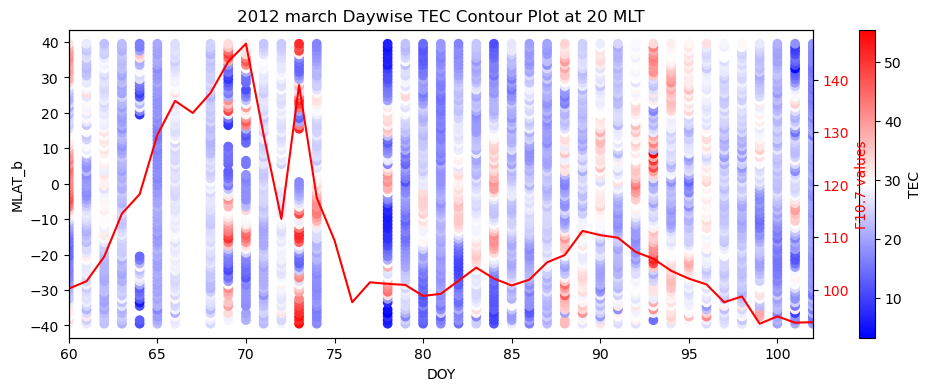

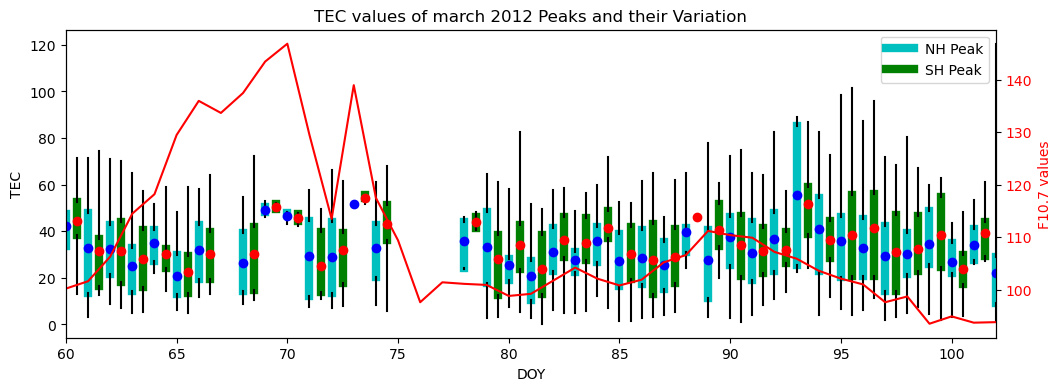

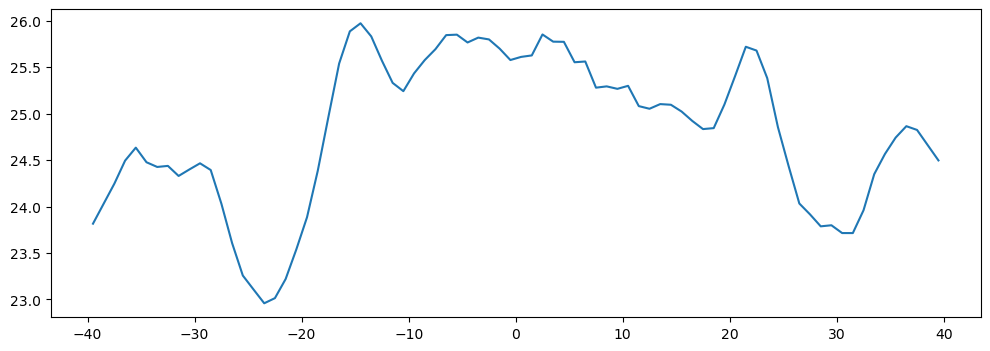

 17%|███████▌                                     | 1/6 [00:01<00:06,  1.24s/it]

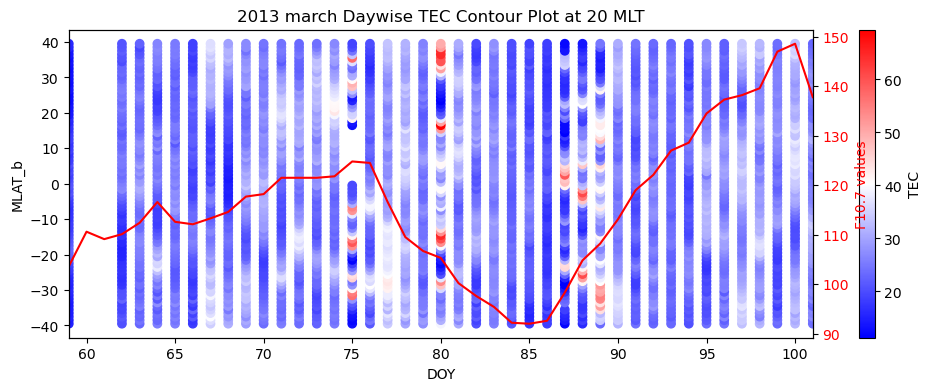

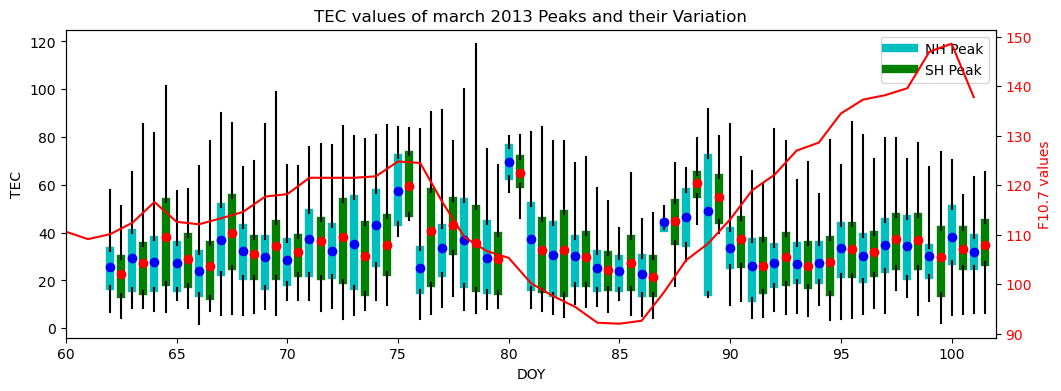

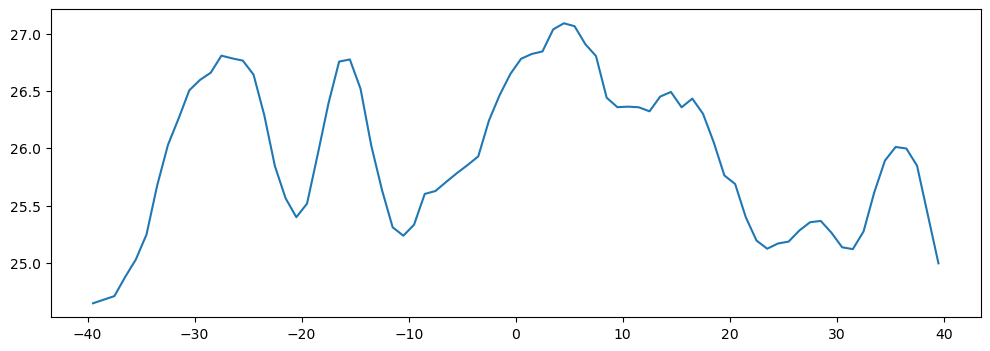

 33%|███████████████                              | 2/6 [00:02<00:05,  1.48s/it]

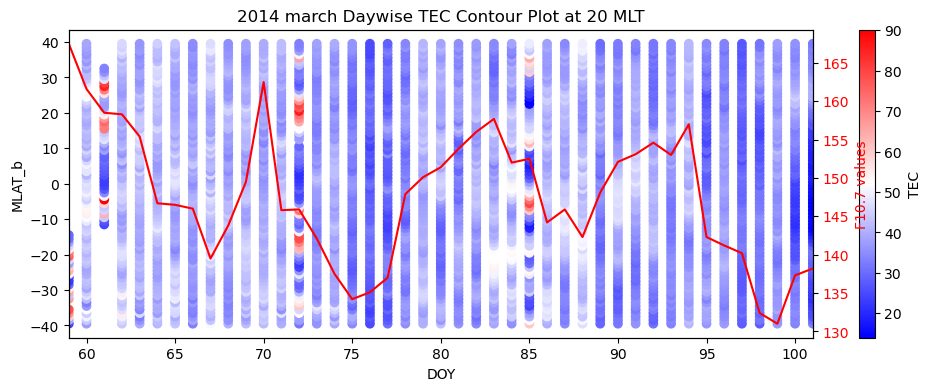

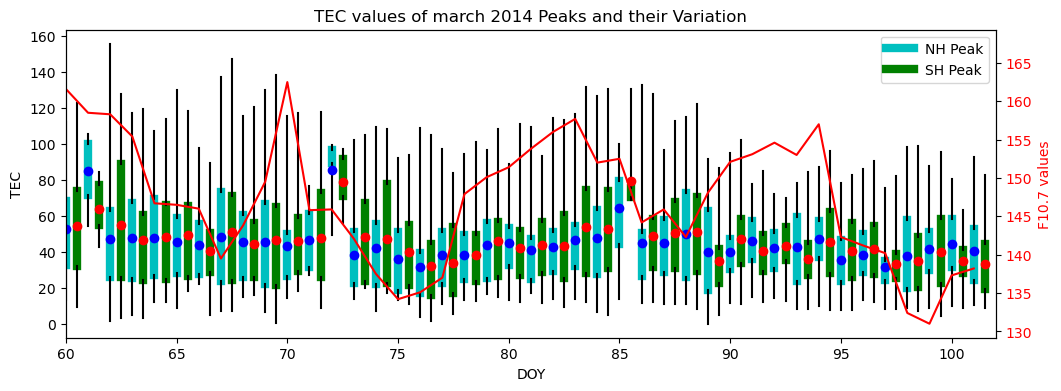

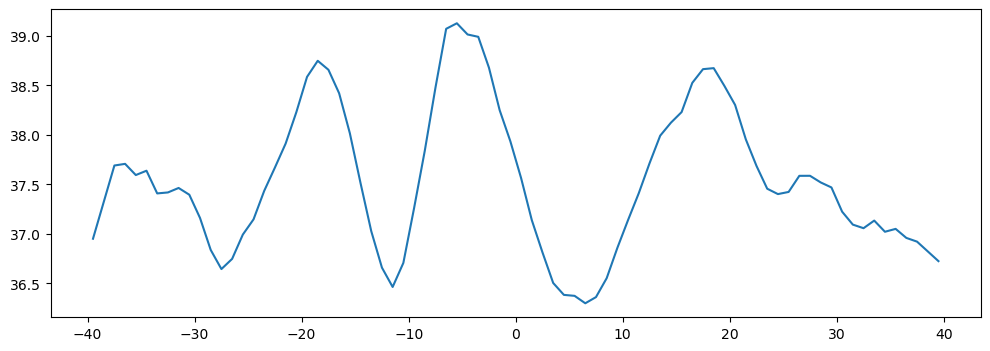

 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.41s/it]

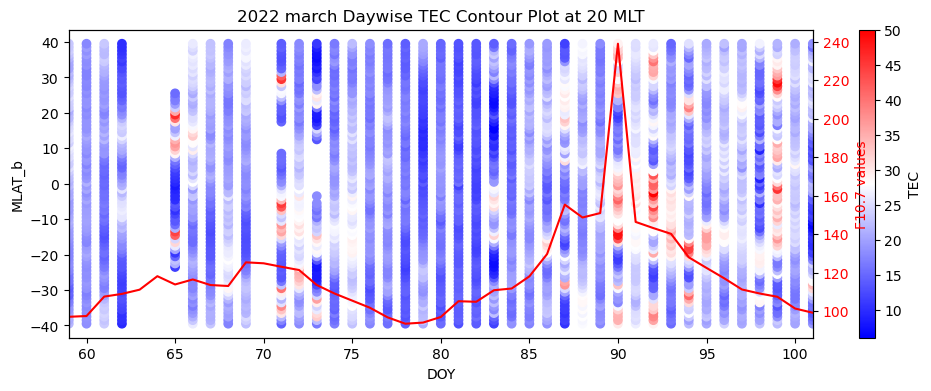

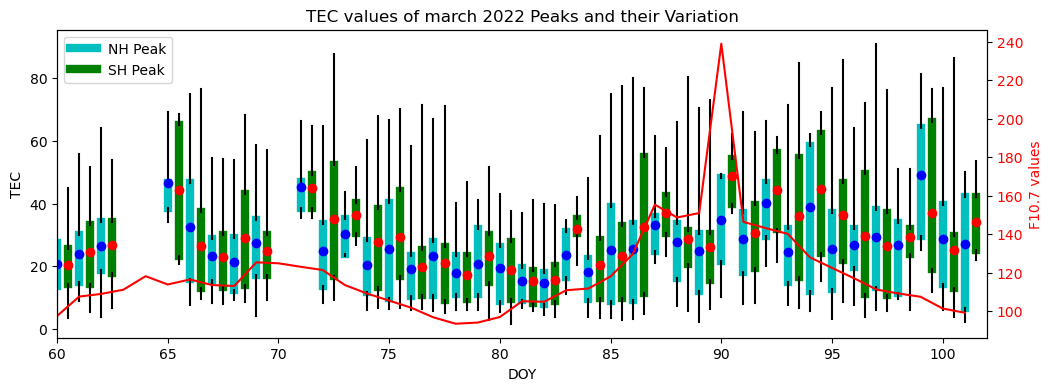

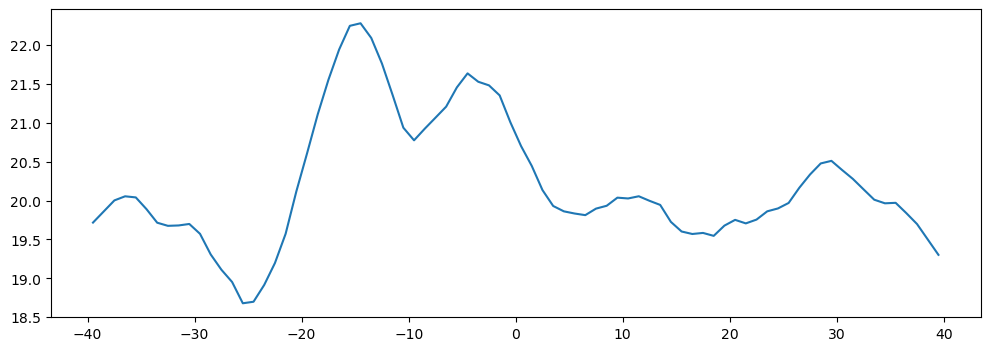

 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.39s/it]

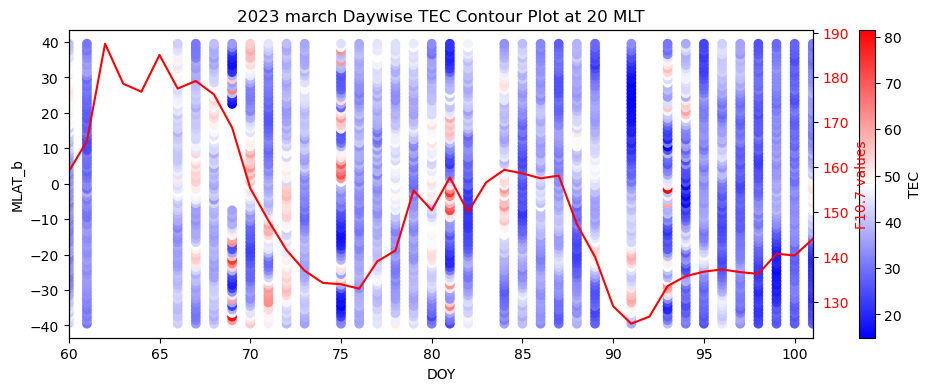

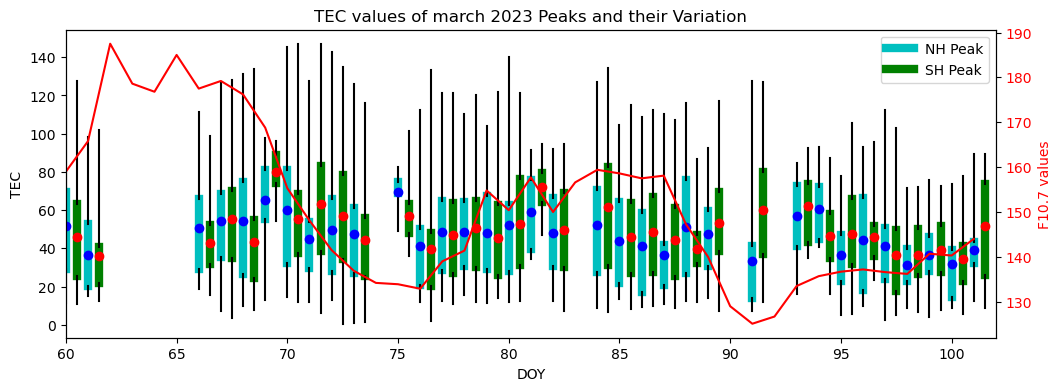

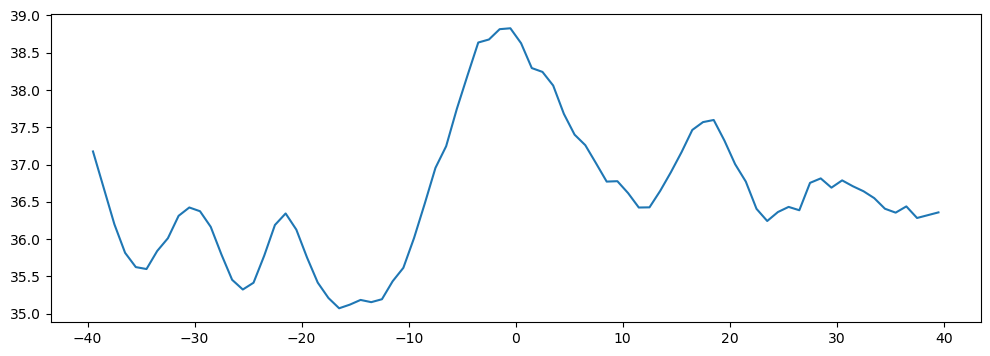

 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.31s/it]

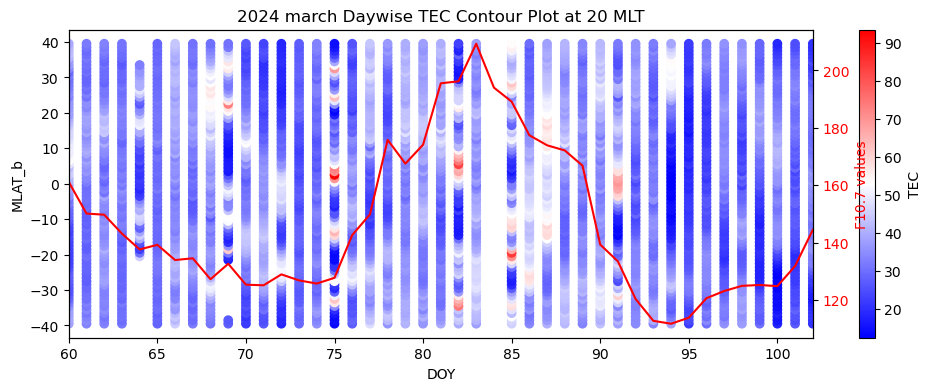

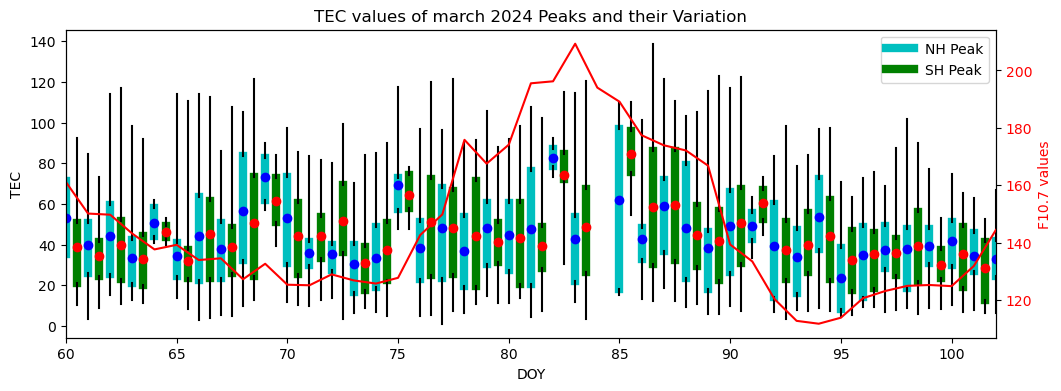

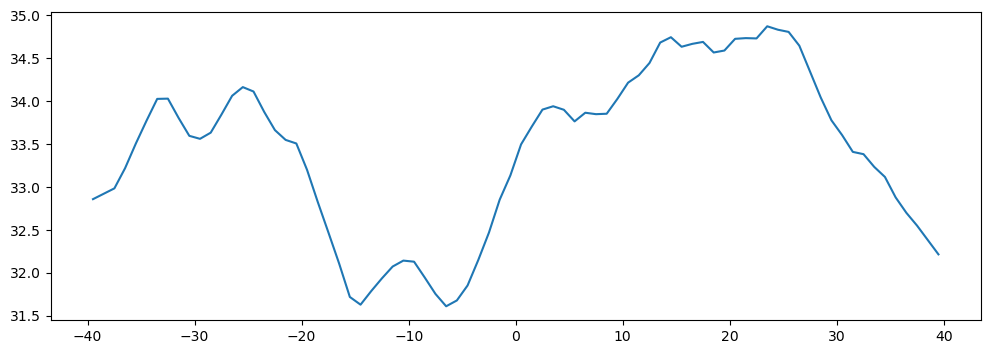

100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.33s/it]


In [25]:
if month == 'dec' or month == 'sept':
    years = [2012, 2013, 2014, 2022, 2023]
else:
    years = [2012, 2013, 2014, 2022, 2023, 2024]
    
for year in tqdm(years):
    i = year - 2000
    result_hr = mlt_yr_cmp[i]
    #print(result_hr)

    '''
    filtered = []
    for t in result_hr['DOY'].unique():
        result_f = result_hr[result_hr['DOY'] == t].reset_index(drop=True)
        fit = savgol_filter(np.array(result_f.TEC), 5, 1)
        filtered.extend(fit)
    result_hr['TEC'] = filtered
    #result_hr = result_hr.groupby(['MLAT_b', 'MLT_b'], observed=False).sum().reset_index()
    '''
    
    '''
    # Pivot the data to create a 2D grid for contour plotting
    grid = result_hr.pivot_table(index='MLAT_b', columns='DOY', values='TEC')    
    x = grid.columns.values  # DOY values
    y = grid.index.values    # MLAT_b values
    X, Y = np.meshgrid(x, y) # Meshgrid for contour plotting
    Z = grid.values          # TEC values
    
    if np.max(Z) <= 20:
        contour_levels = list(range(0, 21, 5))
    elif np.max(Z) <= 40:
        contour_levels = list(range(0, 41, 5))
    elif np.max(Z) <= 60:
        contour_levels = list(range(0, 61, 5))
    elif np.max(Z) <= 80:
        contour_levels = list(range(0, 81, 5))
    elif np.max(Z) <= 100:
        contour_levels = list(range(0, 101, 5))
    elif np.max(Z) <= 120:
        contour_levels = list(range(0, 121, 5))
    elif np.max(Z) <= 140:
        contour_levels = list(range(0, 141, 5))
    elif np.max(Z) <= 160:
        contour_levels = list(range(0, 161, 5))

    plt.figure(figsize=(12, 6))
    contour = plt.contourf(X, Y, Z, levels=contour_levels, cmap='jet')  # You can adjust the colormap
    cbar = plt.colorbar(contour)
    cbar.set_label('TEC')
    plt.xlabel('DOY')
    plt.ylabel('MLAT_b')
    plt.title('TEC Contour Plot')
    plt.show()
    '''
    
    
    file = f'{work}Qingyu_Cesar_EIA_IHA/kp3_index_values/kp_{str(year)}_{month}.txt'
    kp = pd.read_csv(file,sep=r'\s+')
    kp.loc[kp['DOY'] < 40, 'DOY'] += 365
    kp = kp.drop(['Hour','Year'], axis=1)    
    kp = kp.groupby('DOY')[['Kp', 'F10.7']].mean().reset_index()


    
    fig, ax1 = plt.subplots(figsize=(12, 4))
    sc = ax1.scatter(result_hr.DOY, result_hr.MLAT_b, c  = result_hr.TEC, cmap='bwr')  # You can adjust the colormap
    ax1.set_xlabel('DOY')
    ax1.set_ylabel('MLAT_b')
    ax1.set_title(f'{year} {month} Daywise TEC Contour Plot at {hr} MLT')
    fig.colorbar(sc, label='TEC')
    ax1.set_xlim(min(result_hr.DOY), max(result_hr.DOY))
    ax2 = ax1.twinx()
    ax2.plot(kp.DOY, kp['F10.7'], 'r-')
    ax2.set_ylabel('F10.7 values', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    fig.show()
    fig.savefig(f'{work}Qingyu_Cesar_EIA_IHA/outputs/eia_peaks/{month}/box_plot_peaks/doy_mlat_{month}_{str(year)}.jpg')
    #print(result_hr)

    
    north_max_val = result_hr[result_hr['MLAT_b'] > 5].groupby('DOY')['TEC'].idxmax()
    south_max_val = result_hr[result_hr['MLAT_b'] < -5].groupby('DOY')['TEC'].idxmax()
    north_max_val = north_max_val.dropna()
    south_max_val = south_max_val.dropna()
    max_north = result_hr.loc[north_max_val]
    max_south = result_hr.loc[south_max_val]


    fig, ax1 = plt.subplots(figsize=(12,4))
    for idx, (i, mean, min_val, max_val, q25, q75) in enumerate(zip(max_north['DOY'], max_north['TEC'], max_north['min'], max_north['max'], max_north['q25'], max_north['q75'])):
        ax1.plot([i, i], [q25, q75], color='c', label='NH Peak' if idx == 0 else "", lw=6)  # Box line
        ax1.plot([i, i], [min_val, q25], color='black', lw=1.5)  # Lower whisker
        ax1.plot([i, i], [q75, max_val], color='black', lw=1.5)  # Upper whisker
        ax1.plot(i, mean, 'bo')  # Mean point
        
    for idx, (i, mean, min_val, max_val, q25, q75) in enumerate(zip(max_south['DOY'], max_south['TEC'], max_south['min'], max_south['max'], max_south['q25'], max_south['q75'])):
        i += 0.5
        ax1.plot([i, i], [q25, q75], color='g', label='SH Peak' if idx == 0 else "", lw=6)  # Box line
        ax1.plot([i, i], [min_val, q25], color='black', lw=1.5)  # Lower whisker
        ax1.plot([i, i], [q75, max_val], color='black', lw=1.5)  # Upper whisker
        ax1.plot(i, mean, 'ro')  # Mean point
    ax2 = ax1.twinx()
    ax2.plot(kp.DOY, kp['F10.7'], 'r-')
    ax2.set_ylabel('F10.7 values', color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    plt.xlim(min(mlt_yr_cmp[0]['DOY']), max(mlt_yr_cmp[0]['DOY']))
    ax1.legend()
    ax1.set_xlabel('DOY')
    ax1.set_ylabel('TEC')
    plt.title(f'TEC values of {month} {year} Peaks and their Variation')
    #fig.savefig(f'{work}Qingyu_Cesar_EIA_IHA/outputs/eia_peaks/{month}/box_plot_peaks/doy_mlat_{month}_{str(year)}.jpg')
    plt.show()

    average_tec_per_mlat = result_hr.groupby('MLAT_b', observed=False)['TEC'].mean().reset_index()
    fit = savgol_filter(np.array(average_tec_per_mlat.TEC), 5, 1)
    filtered.extend(fit)
    #print(average_tec_per_mlat)
    
    plt.figure(figsize=(12,4))
    plt.plot(average_tec_per_mlat.MLAT_b, fit)
    plt.show()

# Comparing Asymmetry Index

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import cartopy.crs as ccrs
from tqdm import tqdm
from apexpy import Apex
import datetime as dt


In [10]:
# Choose the system: i -> 0:tacc, 1:mac, 2:ganymede
i = 0

if i == 0:
    work = '/work/10028/prasoonv/ls6/repo/sat-interp-tid-analysis/'
    scratch = '/scratch/10028/prasoonv/' 
elif i == 1:
    work = '/Users/prasoonv/repo/sat-interp-tid-analysis/'
    scratch = '/Users/prasoonv/repo/sat-interp-tid-analysis/scratch/'
elif i == 2:
    work = '/home/pxv220016/prasoon/data/sat_interp_repo/sat-interp-tid-analysis/'
    scratch = '/home/pxv220017/scratch/'

import sys
sys.path.append('')
sys.path.append(f'{work}prasoon_utility_programs')
sys.path.append(f'{work}Qingyu_Cesar_EIA_IHA')
import functions

In [ ]:
month = 'sept' # 'march'

if month == 'sept' or month == 'march':
    phase = 'equinox'
else:
    phase = 'solstice'

if month == 'sept' or month == 'dec':
    years = list(range(2006, 2009)) + list(range(2017, 2020)) + list(range(2000, 2003)) + list(range(2012, 2015)) + list(range(2022, 2024))
else:
    years = list(range(2006, 2009)) + list(range(2017, 2020)) + list(range(2000, 2003)) + list(range(2012, 2015)) + list(range(2022, 2025))


asy_ind = []

for y in years:
    f = pd.read_csv(f'{work}Qingyu_Cesar_EIA_IHA/outputs/{month}/asy_{str(y)}_{month}.csv')
    asy_ind.append(f)

In [82]:
if month == 'sept' or month == 'dec':
    solar_cyc = [[list(range(2006, 2009))], [list(range(2017, 2020))], [list(range(2000, 2003))], [list(range(2012, 2015))], [list(range(2022, 2024))]]
else:
    solar_cyc = [[list(range(2006, 2009))], [list(range(2017, 2020))], [list(range(2000, 2003))], [list(range(2012, 2015))], [list(range(2022, 2025))]]


sc = ['Baseline Min-SC24', 'Baseline Min-SC25', 'Baseline Max-SC23', 'Baseline Max-SC24', 'Baseline Max-SC25']

sc_base = []

for s, n in tqdm(zip(solar_cyc, sc)):

    fig = plt.figure(figsize=(12,8))

    for periods in s:
        columns = ['mlt', 'asy']
        baseline = pd.DataFrame(columns=columns)

        for p in periods:
            a = pd.read_csv(f'{work}/Qingyu_Cesar_EIA_IHA/outputs/{month}/asy_{str(p)}_{month}.csv')
            a = a.drop(['mlat_n', 'mlat_s', 'tec_n', 'tec_s'], axis=1)
            #a = a.dropna(subset = 'asy')
            baseline = pd.concat([baseline, a], axis=0).reset_index(drop=True)
            plt.plot(a.mlt, a.asy, linestyle = '--', label = f'{str(p)} ASY Index')
        
        baseline = baseline.sort_values(by=['mlt'], ascending=[True])
        bins_mlt = pd.cut(baseline['mlt'], bins=pd.interval_range(start=0, end=24, freq=0.75))
        baseline['mlt'] = bins_mlt
        baseline = baseline.groupby(['mlt'])['asy'].mean().reset_index()
        baseline['mlt'] = baseline['mlt'].apply(lambda x: x.mid)
        baseline['mlt'] = baseline['mlt'].astype(float)
        baseline.dropna(inplace=True)
        plt.plot(baseline.mlt, baseline.asy, label=n, linewidth=3)
        print(baseline)
        break
    
    plt.ylim(-30,30)
    plt.axhline(y=0, color='red', linestyle='-.')
    plt.legend()
    plt.title('Asymmetry Index of the EIA Peak Magnitude')
    plt.ylabel('ASY index (%)')
    plt.xlabel('MLT (Hours)')
    plt.grid(True)
    fig.savefig(f'{work}Qingyu_Cesar_EIA_IHA/outputs/asy_ind/{month}/{n[-8:]}_{month}.jpg')
    plt.show()
    
    sc_base.append(baseline)


0it [00:00, ?it/s]

1it [00:00,  8.49it/s]

       mlt        asy
17  13.125  10.049760
18  13.875  12.249435
19  14.625  14.796540
20  15.375  17.752089
21  16.125  24.421050
22  16.875  20.274114
23  17.625  17.108996
24  18.375  13.252168
25  19.125  15.143293
26  19.875  15.853694
27  20.625  11.348634
28  21.375   8.329782
29  22.125   2.081856
30  22.875   2.258801
31  23.625   5.583339
       mlt        asy
17  13.125   8.479868
18  13.875  10.515567
19  14.625  10.997735
20  15.375   7.892180
21  16.125  10.431859
22  16.875   8.658075
23  17.625   5.751419
24  18.375   5.070644
25  19.125   2.191652
26  19.875  -0.360423
27  20.625   1.415835
28  21.375   2.781555
29  22.125   3.721693
30  22.875  13.217005
       mlt        asy
17  13.125  29.133674
18  13.875  19.527010
19  14.625  20.239348
20  15.375  10.738350
21  16.125   8.943128
22  16.875   8.630654
23  17.625   9.123485
24  18.375   6.940371
25  19.125   6.167420
26  19.875   9.607993
27  20.625  13.868344
28  21.375  19.595431
29  22.125   8.849994
30  22.875

5it [00:00, 10.91it/s]

       mlt        asy
18  13.875  16.964922
19  14.625  18.024702
20  15.375  15.171170
21  16.125  12.841654
22  16.875  11.117760
23  17.625   9.822784
24  18.375   9.736567
25  19.125  11.005506
26  19.875   7.454038
27  20.625  10.454204
28  21.375  14.346315
29  22.125  12.253934
30  22.875  10.443778
31  23.625   1.812995
       mlt        asy
17  13.125  14.942398
18  13.875  15.236616
19  14.625  10.346091
20  15.375   5.622188
21  16.125   3.886455
22  16.875   1.271233
23  17.625  -3.845755
24  18.375  -8.823941
25  19.125 -19.050625
26  19.875 -15.238486
27  20.625  -8.697833
28  21.375  -7.468606
29  22.125  -7.751640
30  22.875  -4.070954
31  23.625 -10.848854


In [83]:
color = ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']
marker = ['o', 'x', 'D', 's']


# Solar maxima EIAs
fig = plt.figure(figsize=(12,8))
for s, name in zip(sc_base[3:], sc[3:]):
    plt.plot(s.mlt, s.asy, label=name, linewidth=3)
n = 0

for a, y in zip(asy_ind[9:], years[9:]):
    plt.plot(a.mlt, a.asy, linestyle = '--', c = color[n])
    if y < 2011:
        m = marker[0]
    elif y < 2021:
        m = marker[1]
    else:
        m = marker[2]
    plt.scatter(a.mlt, a.asy, marker = m, c = color[n], label=f'{str(y)} ASY Index', s=50)
    n = n + 1

plt.ylim(-30,30)
plt.axhline(y=0, color='red', linestyle='-.')
plt.legend()
plt.title('Asymmetry Index of the EIA Peak Magnitude')
plt.ylabel('ASY index (%)')
plt.xlim(13,22)
plt.xlabel('MLT (Hours)')
plt.grid(True)
fig.savefig(f'{work}Qingyu_Cesar_EIA_IHA/outputs/asy_ind/{month}/asy_all_MAX_{month}.jpg')
fig.show()

# Solar minima EIAs
fig = plt.figure(figsize=(12,8))
for s, name in zip(sc_base[:2], sc[:2]):
    plt.plot(s.mlt, s.asy, label=name, linewidth=3)
n = 0

for a, y in zip(asy_ind[:6], years[:6]):
    plt.plot(a.mlt, a.asy, linestyle = '--', c = color[n])
    if y < 2011:
        m = marker[0]
    elif y < 2021:
        m = marker[1]
    else:
        m = marker[2]
    plt.scatter(a.mlt, a.asy, marker = m, c = color[n], label=str(y) + ' ASY Index', s=50)
    n = n + 1

plt.ylim(-30,30)
plt.axhline(y=0, color='red', linestyle='-.')
plt.legend()
plt.title('Asymmetry Index of the EIA Peak Magnitude')
plt.ylabel('ASY index (%)')
plt.xlim(13,22)
plt.xlabel('MLT (Hours)')
plt.grid(True)
fig.savefig(f'{work}Qingyu_Cesar_EIA_IHA/outputs/asy_ind/{month}/asy_all_MIN_{month}.jpg')
plt.show()



In [84]:
color = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

# Solar Max Peak Locations
n = 0
fig = plt.figure(figsize=(12,8))
for a, y in zip(asy_ind[6:], years[6:]):
    a_n = a[a.mlat_n > 8].reset_index(drop=True)
    a_s = a[a.mlat_s < -8].reset_index(drop=True)
    if y < 2003:
        mlat = list(a_s.mlat_s)
        time = list(a_s.mlt)
    else:
        mlat = list(a_n.mlat_n) + list(a_s.mlat_s)
        time = list(a_n.mlt) + list(a_s.mlt)
        plt.plot(list(a_n.mlt), list(a_n.mlat_n), c=color[n])
    plt.scatter(time, mlat, c=color[n], label = str(y))
    plt.plot(list(a_s.mlt), list(a_s.mlat_s), c=color[n])
    n = n+1
    
if month == 'june' or month == 'dec':
    plt.ylim(-15,30)
else:
    plt.ylim(-20,20)
plt.xlim(13,22)
plt.legend()
plt.title('Position of NH SH Peaks During Solar Maximas')
plt.ylabel('MLAT')
plt.xlabel('MLT (Hours)')
plt.grid(True)
fig.savefig(f'{work}Qingyu_Cesar_EIA_IHA/outputs/asy_ind/{month}/pos_all_MAX_{month}.jpg')
fig.show()


# Solar Min Peak Locations
fig = plt.figure(figsize=(12,8))
n = 0
for a, y in zip(asy_ind[:6], years[:6]):
    a_n = a[a.mlat_n > 8].reset_index(drop=True)
    a_s = a[a.mlat_s < -8].reset_index(drop=True)
    if y < 2003:
        mlat = list(a_s.mlat_s)
        time = list(a_s.mlt)
    else:
        mlat = list(a_n.mlat_n) + list(a_s.mlat_s)
        time = list(a_n.mlt) + list(a_s.mlt)
        plt.plot(list(a_s.mlt), list(a_s.mlat_s), c=color[n])
    plt.scatter(time, mlat, c = color[n], label=str(y))
    plt.plot(list(a_n.mlt), list(a_n.mlat_n), c=color[n])
    n = n + 1

if month == 'june' or month == 'dec':
    plt.ylim(-20, 30)
else:
    plt.ylim(-15,15)
plt.xlim(13,20)
plt.legend()
plt.title('Position of NH SH Peaks During Solar Minimas')
plt.ylabel('MLAT')
plt.xlabel('MLT (Hours)')
plt.grid(True)
fig.savefig(f'{work}Qingyu_Cesar_EIA_IHA/outputs/asy_ind/{month}/pos_all_MIN_{month}.jpg')
plt.show()
